# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
import time
# wait_to_make = "trained_list/stacking.txt"
# count = 0
# while 1:
#     if os.path.exists(wait_to_make):
#         break
#     print(f'sleep {count} h')
#     time.sleep(3600)
#     count+=1
    
local = True

In [2]:
EXP_NAME = "anferico-bert-for-patents"


In [3]:
# !nvidia-smi

In [4]:
# ! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime
if local:
    INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
else:
    INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'

OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "anferico/bert-for-patents"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model or "medium" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
    else:
        hidden_state = -1
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=8
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=8
    
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [8]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [9]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [10]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig,AutoModelForTokenClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = torch.device('cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.0
transformers.__version__: 4.16.2
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [12]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [13]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [14]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

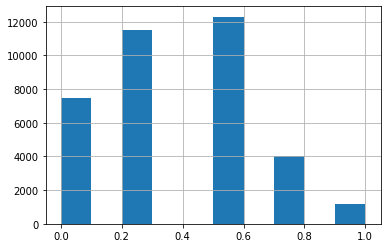

In [15]:
train['score'].hist()

In [16]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [17]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [18]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [19]:
# !pip install --no-cache-dir sentencepiece

In [20]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



# Dataset

In [21]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 117


In [22]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [23]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [24]:
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()

        self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
                                                                                          nhead=nhead),
                                                 num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out

In [25]:
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
        
#         # self.feature_extractor = AutoModelForTokenClassification.from_pretrained(OUTPUT_DIR+'extractor/')
#         self.feature_extractor = AutoModelForTokenClassification.from_pretrained(CFG.model,)
#         self.feature_extractor.save_pretrained(OUTPUT_DIR+'extractor/')
#         in_features = self.feature_extractor.classifier.in_features
#         self.attention = TransformerHead(in_features=in_features, max_length=cfg.max_len, num_layers=1, nhead=8, num_targets=1)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.attention.out_features, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self._init_weights(self.attention)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
#         # feature = torch.mean(last_hidden_states, 1)
#         feature = self.attention(last_hidden_states)
        
#         return feature


#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         try:
#             output = self.fc(self.fc_dropout(feature))
#         except Exception as e:
#             print(feature.shape)
#             print(e)
#             exit()
#         return output

In [26]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output
    


# Helpler functions

In [27]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [28]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            # if fold in [0,1,2]:
                #continue
               # print（f”￥０r３３［３８；５；４０m＝＝＝＝＝＝＝＝＝＝ this fold is pass ￥ontinue
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========


Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3419] Elapsed 0m 0s (remain 32m 32s) Loss: 0.8533(0.8533) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 31s (remain 17m 1s) Loss: 0.7355(0.6693) Grad: 277729.0938  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 1s (remain 16m 27s) Loss: 0.8087(0.6723) Grad: 60608.8711  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 1m 32s (remain 15m 56s) Loss: 0.6656(0.6698) Grad: 23506.1758  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 2m 3s (remain 15m 26s) Loss: 0.5428(0.6645) Grad: 21639.1406  LR: 0.00001999  
Epoch: [1][500/3419] Elapsed 2m 33s (remain 14m 55s) Loss: 0.6307(0.6562) Grad: 18749.2559  LR: 0.00001998  
Epoch: [1][600/3419] Elapsed 3m 4s (remain 14m 24s) Loss: 0.6442(0.6590) Grad: 4393.8447  LR: 0.00001998  
Epoch: [1][700/3419] Elapsed 3m 35s (remain 13m 54s) Loss: 0.6804(0.6623) Grad: 6287.8779  LR: 0.00001997  
Epoch: [1][800/3419] Elapsed 4m 5s (remain 13m 23s) Loss: 0.6846(0.6651) Grad: 6830.2900  LR: 0.00001996  
Epoch: [1][900/3419] Elapsed 4m 36s 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 49s) Loss: 0.6077(0.6077) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 23s) Loss: 0.6258(0.6506) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 14s) Loss: 0.5532(0.6527) 
EVAL: [300/1140] Elapsed 0m 23s (remain 1m 6s) Loss: 0.7711(0.6531) 
EVAL: [400/1140] Elapsed 0m 31s (remain 0m 58s) Loss: 0.7348(0.6562) 
EVAL: [500/1140] Elapsed 0m 39s (remain 0m 50s) Loss: 0.6440(0.6550) 
EVAL: [600/1140] Elapsed 0m 47s (remain 0m 42s) Loss: 0.6440(0.6528) 
EVAL: [700/1140] Elapsed 0m 55s (remain 0m 34s) Loss: 0.6621(0.6527) 
EVAL: [800/1140] Elapsed 1m 3s (remain 0m 26s) Loss: 0.6621(0.6518) 
EVAL: [900/1140] Elapsed 1m 11s (remain 0m 18s) Loss: 0.5895(0.6528) 
EVAL: [1000/1140] Elapsed 1m 19s (remain 0m 10s) Loss: 0.6803(0.6538) 
EVAL: [1100/1140] Elapsed 1m 27s (remain 0m 3s) Loss: 0.6803(0.6545) 


Epoch 1 - avg_train_loss: 0.6614  avg_val_loss: 0.6547  time: 1141s
Epoch 1 - Score: 0.0183
Epoch 1 - Save Best Score: 0.0183 Model


EVAL: [1139/1140] Elapsed 1m 30s (remain 0m 0s) Loss: 0.7970(0.6547) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 36m 5s) Loss: 0.6489(0.6489) Grad: 76351.5156  LR: 0.00001924  
Epoch: [2][100/3419] Elapsed 0m 31s (remain 17m 7s) Loss: 0.6895(0.6664) Grad: 85878.1094  LR: 0.00001919  
Epoch: [2][200/3419] Elapsed 1m 2s (remain 16m 32s) Loss: 0.7666(0.6586) Grad: 181179.3438  LR: 0.00001915  
Epoch: [2][300/3419] Elapsed 1m 32s (remain 16m 1s) Loss: 0.6995(0.6605) Grad: 54988.1484  LR: 0.00001910  
Epoch: [2][400/3419] Elapsed 2m 3s (remain 15m 29s) Loss: 0.6143(0.6597) Grad: 44179.5352  LR: 0.00001905  
Epoch: [2][500/3419] Elapsed 2m 34s (remain 14m 57s) Loss: 0.6782(0.6587) Grad: 52713.0430  LR: 0.00001900  
Epoch: [2][600/3419] Elapsed 3m 4s (remain 14m 26s) Loss: 0.5917(0.6594) Grad: 133958.2188  LR: 0.00001895  
Epoch: [2][700/3419] Elapsed 3m 35s (remain 13m 55s) Loss: 0.6852(0.6594) Grad: 60448.1328  LR: 0.00001890  
Epoch: [2][800/3419] Elapsed 4m 6s (remain 13m 24s) Loss: 0.6706(0.6599) Grad: 28714.9863  LR: 0.00001885  
Epoch: [2][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 40s) Loss: 0.5943(0.5943) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 23s) Loss: 0.6223(0.6604) 
EVAL: [200/1140] Elapsed 0m 15s (remain 1m 14s) Loss: 0.5105(0.6637) 
EVAL: [300/1140] Elapsed 0m 23s (remain 1m 6s) Loss: 0.8457(0.6642) 
EVAL: [400/1140] Elapsed 0m 31s (remain 0m 58s) Loss: 0.7899(0.6689) 
EVAL: [500/1140] Elapsed 0m 39s (remain 0m 50s) Loss: 0.6502(0.6672) 
EVAL: [600/1140] Elapsed 0m 47s (remain 0m 42s) Loss: 0.6502(0.6638) 
EVAL: [700/1140] Elapsed 0m 55s (remain 0m 34s) Loss: 0.6781(0.6635) 
EVAL: [800/1140] Elapsed 1m 3s (remain 0m 26s) Loss: 0.6781(0.6622) 
EVAL: [900/1140] Elapsed 1m 11s (remain 0m 18s) Loss: 0.5664(0.6638) 
EVAL: [1000/1140] Elapsed 1m 19s (remain 0m 10s) Loss: 0.7061(0.6653) 
EVAL: [1100/1140] Elapsed 1m 26s (remain 0m 3s) Loss: 0.7061(0.6663) 


Epoch 2 - avg_train_loss: 0.6567  avg_val_loss: 0.6666  time: 1139s
Epoch 2 - Score: 0.0242
Epoch 2 - Save Best Score: 0.0242 Model


EVAL: [1139/1140] Elapsed 1m 29s (remain 0m 0s) Loss: 0.8857(0.6666) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 32m 40s) Loss: 0.7722(0.7722) Grad: inf  LR: 0.00001707  
Epoch: [3][100/3419] Elapsed 0m 31s (remain 17m 3s) Loss: 0.6975(0.6575) Grad: 85364.9609  LR: 0.00001699  
Epoch: [3][200/3419] Elapsed 1m 1s (remain 16m 30s) Loss: 0.7267(0.6537) Grad: 127364.2266  LR: 0.00001691  
Epoch: [3][300/3419] Elapsed 1m 32s (remain 15m 58s) Loss: 0.6162(0.6544) Grad: 85220.9297  LR: 0.00001682  
Epoch: [3][400/3419] Elapsed 2m 3s (remain 15m 27s) Loss: 0.7589(0.6558) Grad: 170141.3906  LR: 0.00001674  
Epoch: [3][500/3419] Elapsed 2m 33s (remain 14m 56s) Loss: 0.7215(0.6560) Grad: 110985.3516  LR: 0.00001665  
Epoch: [3][600/3419] Elapsed 3m 4s (remain 14m 25s) Loss: 0.7211(0.6573) Grad: 148613.8594  LR: 0.00001657  
Epoch: [3][700/3419] Elapsed 3m 35s (remain 13m 54s) Loss: 0.5666(0.6571) Grad: 119071.0703  LR: 0.00001648  
Epoch: [3][800/3419] Elapsed 4m 6s (remain 13m 24s) Loss: 0.6909(0.6572) Grad: 78534.7812  LR: 0.00001639  
Epoch: [3][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][3418/3419] Elapsed 17m 31s (remain 0m 0s) Loss: 0.5196(0.6566) Grad: 64610.0586  LR: 0.00001383  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 50s) Loss: 0.5955(0.5955) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 23s) Loss: 0.6212(0.6562) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 14s) Loss: 0.5186(0.6592) 
EVAL: [300/1140] Elapsed 0m 23s (remain 1m 6s) Loss: 0.8264(0.6597) 
EVAL: [400/1140] Elapsed 0m 31s (remain 0m 58s) Loss: 0.7751(0.6641) 
EVAL: [500/1140] Elapsed 0m 39s (remain 0m 50s) Loss: 0.6468(0.6625) 
EVAL: [600/1140] Elapsed 0m 47s (remain 0m 42s) Loss: 0.6468(0.6594) 
EVAL: [700/1140] Elapsed 0m 55s (remain 0m 34s) Loss: 0.6725(0.6591) 
EVAL: [800/1140] Elapsed 1m 3s (remain 0m 26s) Loss: 0.6725(0.6579) 
EVAL: [900/1140] Elapsed 1m 11s (remain 0m 18s) Loss: 0.5699(0.6593) 
EVAL: [1000/1140] Elapsed 1m 19s (remain 0m 10s) Loss: 0.6981(0.6607) 
EVAL: [1100/1140] Elapsed 1m 27s (remain 0m 3s) Loss: 0.6982(0.6616) 


Epoch 3 - avg_train_loss: 0.6566  avg_val_loss: 0.6619  time: 1142s
Epoch 3 - Score: 0.0051


EVAL: [1139/1140] Elapsed 1m 30s (remain 0m 0s) Loss: 0.8630(0.6619) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 24m 2s) Loss: 0.6879(0.6879) Grad: 173995.4219  LR: 0.00001383  
Epoch: [4][100/3419] Elapsed 0m 31s (remain 17m 1s) Loss: 0.6728(0.6625) Grad: 74373.5625  LR: 0.00001372  
Epoch: [4][200/3419] Elapsed 1m 1s (remain 16m 30s) Loss: 0.5924(0.6610) Grad: 118890.8203  LR: 0.00001361  
Epoch: [4][300/3419] Elapsed 1m 32s (remain 16m 0s) Loss: 0.7328(0.6582) Grad: 134869.8750  LR: 0.00001351  
Epoch: [4][400/3419] Elapsed 2m 3s (remain 15m 28s) Loss: 0.6046(0.6595) Grad: 130040.2734  LR: 0.00001340  
Epoch: [4][500/3419] Elapsed 2m 34s (remain 14m 57s) Loss: 0.5646(0.6573) Grad: 112705.3828  LR: 0.00001329  
Epoch: [4][600/3419] Elapsed 3m 4s (remain 14m 25s) Loss: 0.6627(0.6564) Grad: 10250.2461  LR: 0.00001318  
Epoch: [4][700/3419] Elapsed 3m 35s (remain 13m 55s) Loss: 0.6820(0.6554) Grad: 25531.9062  LR: 0.00001307  
Epoch: [4][800/3419] Elapsed 4m 6s (remain 13m 24s) Loss: 0.7013(0.6548) Grad: 47939.5312  LR: 0.00001296  
Epoch: [4][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][3418/3419] Elapsed 17m 29s (remain 0m 0s) Loss: 0.6432(0.6565) Grad: 19585.0293  LR: 0.00001000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 50s) Loss: 0.6052(0.6052) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 23s) Loss: 0.6244(0.6506) 
EVAL: [200/1140] Elapsed 0m 15s (remain 1m 14s) Loss: 0.5476(0.6529) 
EVAL: [300/1140] Elapsed 0m 23s (remain 1m 6s) Loss: 0.7780(0.6532) 
EVAL: [400/1140] Elapsed 0m 31s (remain 0m 58s) Loss: 0.7396(0.6565) 
EVAL: [500/1140] Elapsed 0m 39s (remain 0m 50s) Loss: 0.6436(0.6553) 
EVAL: [600/1140] Elapsed 0m 47s (remain 0m 42s) Loss: 0.6436(0.6530) 
EVAL: [700/1140] Elapsed 0m 55s (remain 0m 34s) Loss: 0.6628(0.6528) 
EVAL: [800/1140] Elapsed 1m 3s (remain 0m 26s) Loss: 0.6628(0.6519) 
EVAL: [900/1140] Elapsed 1m 11s (remain 0m 18s) Loss: 0.5860(0.6530) 
EVAL: [1000/1140] Elapsed 1m 19s (remain 0m 10s) Loss: 0.6820(0.6540) 
EVAL: [1100/1140] Elapsed 1m 26s (remain 0m 3s) Loss: 0.6820(0.6547) 


Epoch 4 - avg_train_loss: 0.6565  avg_val_loss: 0.6549  time: 1139s
Epoch 4 - Score: 0.0116


EVAL: [1139/1140] Elapsed 1m 29s (remain 0m 0s) Loss: 0.8054(0.6549) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 22m 31s) Loss: 0.6528(0.6528) Grad: 87353.7266  LR: 0.00001000  
Epoch: [5][100/3419] Elapsed 0m 31s (remain 16m 59s) Loss: 0.7113(0.6630) Grad: 100212.1797  LR: 0.00000989  
Epoch: [5][200/3419] Elapsed 1m 1s (remain 16m 29s) Loss: 0.5988(0.6608) Grad: 124969.8828  LR: 0.00000977  
Epoch: [5][300/3419] Elapsed 1m 32s (remain 15m 58s) Loss: 0.6525(0.6609) Grad: 39588.7461  LR: 0.00000966  
Epoch: [5][400/3419] Elapsed 2m 3s (remain 15m 27s) Loss: 0.6859(0.6619) Grad: 91498.9453  LR: 0.00000954  
Epoch: [5][500/3419] Elapsed 2m 33s (remain 14m 56s) Loss: 0.6104(0.6623) Grad: 124249.5078  LR: 0.00000943  
Epoch: [5][600/3419] Elapsed 3m 4s (remain 14m 25s) Loss: 0.6924(0.6616) Grad: 70048.0391  LR: 0.00000931  
Epoch: [5][700/3419] Elapsed 3m 35s (remain 13m 55s) Loss: 0.6775(0.6611) Grad: 65072.2109  LR: 0.00000920  
Epoch: [5][800/3419] Elapsed 4m 6s (remain 13m 24s) Loss: 0.6752(0.6606) Grad: 54188.9805  LR: 0.00000908  
Epoch: [5][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][3418/3419] Elapsed 17m 30s (remain 0m 0s) Loss: 0.5566(0.6556) Grad: 123528.3203  LR: 0.00000617  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 44s) Loss: 0.6003(0.6003) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 23s) Loss: 0.6220(0.6517) 
EVAL: [200/1140] Elapsed 0m 15s (remain 1m 14s) Loss: 0.5350(0.6543) 
EVAL: [300/1140] Elapsed 0m 23s (remain 1m 6s) Loss: 0.7961(0.6547) 
EVAL: [400/1140] Elapsed 0m 31s (remain 0m 58s) Loss: 0.7526(0.6584) 
EVAL: [500/1140] Elapsed 0m 39s (remain 0m 50s) Loss: 0.6438(0.6570) 
EVAL: [600/1140] Elapsed 0m 47s (remain 0m 42s) Loss: 0.6438(0.6544) 
EVAL: [700/1140] Elapsed 0m 55s (remain 0m 34s) Loss: 0.6655(0.6542) 
EVAL: [800/1140] Elapsed 1m 3s (remain 0m 26s) Loss: 0.6655(0.6531) 
EVAL: [900/1140] Elapsed 1m 11s (remain 0m 18s) Loss: 0.5785(0.6544) 
EVAL: [1000/1140] Elapsed 1m 19s (remain 0m 10s) Loss: 0.6873(0.6555) 
EVAL: [1100/1140] Elapsed 1m 26s (remain 0m 3s) Loss: 0.6873(0.6563) 


Epoch 5 - avg_train_loss: 0.6556  avg_val_loss: 0.6566  time: 1141s
Epoch 5 - Score: -0.0147


EVAL: [1139/1140] Elapsed 1m 30s (remain 0m 0s) Loss: 0.8271(0.6566) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 22m 32s) Loss: 0.6222(0.6222) Grad: 63964.0312  LR: 0.00000617  
Epoch: [6][100/3419] Elapsed 0m 31s (remain 16m 59s) Loss: 0.6990(0.6622) Grad: 81433.4766  LR: 0.00000607  
Epoch: [6][200/3419] Elapsed 1m 1s (remain 16m 28s) Loss: 0.6478(0.6550) Grad: 34027.6523  LR: 0.00000596  
Epoch: [6][300/3419] Elapsed 1m 32s (remain 15m 57s) Loss: 0.6394(0.6558) Grad: 43799.6719  LR: 0.00000586  
Epoch: [6][400/3419] Elapsed 2m 3s (remain 15m 27s) Loss: 0.6494(0.6558) Grad: 30436.5117  LR: 0.00000575  
Epoch: [6][500/3419] Elapsed 2m 33s (remain 14m 56s) Loss: 0.6487(0.6578) Grad: 46615.6250  LR: 0.00000565  
Epoch: [6][600/3419] Elapsed 3m 4s (remain 14m 25s) Loss: 0.5681(0.6571) Grad: 129518.9609  LR: 0.00000555  
Epoch: [6][700/3419] Elapsed 3m 35s (remain 13m 54s) Loss: 0.6952(0.6570) Grad: 69366.8516  LR: 0.00000544  
Epoch: [6][800/3419] Elapsed 4m 6s (remain 13m 24s) Loss: 0.6276(0.6567) Grad: 71445.8828  LR: 0.00000534  
Epoch: [6][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][3418/3419] Elapsed 17m 30s (remain 0m 0s) Loss: 0.6939(0.6556) Grad: 87474.1328  LR: 0.00000293  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 44s) Loss: 0.6042(0.6042) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 23s) Loss: 0.6239(0.6507) 
EVAL: [200/1140] Elapsed 0m 15s (remain 1m 14s) Loss: 0.5452(0.6530) 
EVAL: [300/1140] Elapsed 0m 23s (remain 1m 6s) Loss: 0.7812(0.6534) 
EVAL: [400/1140] Elapsed 0m 31s (remain 0m 58s) Loss: 0.7418(0.6567) 
EVAL: [500/1140] Elapsed 0m 39s (remain 0m 50s) Loss: 0.6435(0.6555) 
EVAL: [600/1140] Elapsed 0m 47s (remain 0m 42s) Loss: 0.6435(0.6531) 
EVAL: [700/1140] Elapsed 0m 55s (remain 0m 34s) Loss: 0.6632(0.6529) 
EVAL: [800/1140] Elapsed 1m 3s (remain 0m 26s) Loss: 0.6632(0.6520) 
EVAL: [900/1140] Elapsed 1m 11s (remain 0m 18s) Loss: 0.5845(0.6531) 
EVAL: [1000/1140] Elapsed 1m 19s (remain 0m 10s) Loss: 0.6828(0.6542) 
EVAL: [1100/1140] Elapsed 1m 26s (remain 0m 3s) Loss: 0.6829(0.6549) 


Epoch 6 - avg_train_loss: 0.6556  avg_val_loss: 0.6551  time: 1140s
Epoch 6 - Score: 0.0213


EVAL: [1139/1140] Elapsed 1m 30s (remain 0m 0s) Loss: 0.8093(0.6551) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][0/3419] Elapsed 0m 0s (remain 22m 12s) Loss: 0.6517(0.6517) Grad: 89344.9688  LR: 0.00000293  
Epoch: [7][100/3419] Elapsed 0m 31s (remain 16m 59s) Loss: 0.6420(0.6514) Grad: 40260.9531  LR: 0.00000285  
Epoch: [7][200/3419] Elapsed 1m 1s (remain 16m 28s) Loss: 0.6941(0.6548) Grad: 89626.0000  LR: 0.00000277  
Epoch: [7][300/3419] Elapsed 1m 32s (remain 15m 57s) Loss: 0.6479(0.6548) Grad: 45689.8320  LR: 0.00000269  
Epoch: [7][400/3419] Elapsed 2m 3s (remain 15m 27s) Loss: 0.4743(0.6541) Grad: 277647.3750  LR: 0.00000261  
Epoch: [7][500/3419] Elapsed 2m 33s (remain 14m 56s) Loss: 0.6747(0.6539) Grad: 77462.2188  LR: 0.00000254  
Epoch: [7][600/3419] Elapsed 3m 4s (remain 14m 25s) Loss: 0.7141(0.6544) Grad: 100882.1719  LR: 0.00000246  
Epoch: [7][700/3419] Elapsed 3m 35s (remain 13m 54s) Loss: 0.6012(0.6544) Grad: 42914.1250  LR: 0.00000238  
Epoch: [7][800/3419] Elapsed 4m 5s (remain 13m 23s) Loss: 0.6430(0.6548) Grad: 14852.9209  LR: 0.00000231  
Epoch: [7][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 39s) Loss: 0.6057(0.6057) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 23s) Loss: 0.6247(0.6506) 
EVAL: [200/1140] Elapsed 0m 15s (remain 1m 14s) Loss: 0.5488(0.6528) 
EVAL: [300/1140] Elapsed 0m 23s (remain 1m 6s) Loss: 0.7764(0.6532) 
EVAL: [400/1140] Elapsed 0m 31s (remain 0m 58s) Loss: 0.7385(0.6564) 
EVAL: [500/1140] Elapsed 0m 39s (remain 0m 50s) Loss: 0.6437(0.6552) 
EVAL: [600/1140] Elapsed 0m 47s (remain 0m 42s) Loss: 0.6437(0.6529) 
EVAL: [700/1140] Elapsed 0m 55s (remain 0m 34s) Loss: 0.6626(0.6527) 
EVAL: [800/1140] Elapsed 1m 3s (remain 0m 26s) Loss: 0.6626(0.6518) 
EVAL: [900/1140] Elapsed 1m 11s (remain 0m 18s) Loss: 0.5868(0.6529) 
EVAL: [1000/1140] Elapsed 1m 19s (remain 0m 10s) Loss: 0.6816(0.6539) 
EVAL: [1100/1140] Elapsed 1m 27s (remain 0m 3s) Loss: 0.6816(0.6546) 


Epoch 7 - avg_train_loss: 0.6554  avg_val_loss: 0.6548  time: 1140s
Epoch 7 - Score: 0.0000


EVAL: [1139/1140] Elapsed 1m 30s (remain 0m 0s) Loss: 0.8035(0.6548) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][0/3419] Elapsed 0m 0s (remain 22m 18s) Loss: 0.6315(0.6315) Grad: 140114.1875  LR: 0.00000076  
Epoch: [8][100/3419] Elapsed 0m 31s (remain 16m 59s) Loss: 0.7296(0.6528) Grad: 134894.2812  LR: 0.00000072  
Epoch: [8][200/3419] Elapsed 1m 1s (remain 16m 28s) Loss: 0.6424(0.6511) Grad: 36222.5312  LR: 0.00000068  
Epoch: [8][300/3419] Elapsed 1m 32s (remain 15m 58s) Loss: 0.5721(0.6516) Grad: 123938.6406  LR: 0.00000064  
Epoch: [8][400/3419] Elapsed 2m 3s (remain 15m 27s) Loss: 0.6758(0.6529) Grad: 55808.5195  LR: 0.00000060  
Epoch: [8][500/3419] Elapsed 2m 33s (remain 14m 56s) Loss: 0.7436(0.6544) Grad: 155813.2812  LR: 0.00000056  
Epoch: [8][600/3419] Elapsed 3m 4s (remain 14m 25s) Loss: 0.7259(0.6559) Grad: 132517.8750  LR: 0.00000052  
Epoch: [8][700/3419] Elapsed 3m 35s (remain 13m 55s) Loss: 0.6812(0.6562) Grad: 56756.7617  LR: 0.00000048  
Epoch: [8][800/3419] Elapsed 4m 6s (remain 13m 24s) Loss: 0.6174(0.6556) Grad: 73022.4297  LR: 0.00000045  
Epoch: [8][900/3419] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][3418/3419] Elapsed 17m 30s (remain 0m 0s) Loss: 0.6046(0.6552) Grad: 77832.6094  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 45s) Loss: 0.6060(0.6060) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 23s) Loss: 0.6249(0.6506) 
EVAL: [200/1140] Elapsed 0m 15s (remain 1m 14s) Loss: 0.5495(0.6528) 
EVAL: [300/1140] Elapsed 0m 23s (remain 1m 6s) Loss: 0.7756(0.6532) 
EVAL: [400/1140] Elapsed 0m 31s (remain 0m 58s) Loss: 0.7379(0.6563) 
EVAL: [500/1140] Elapsed 0m 39s (remain 0m 50s) Loss: 0.6437(0.6552) 
EVAL: [600/1140] Elapsed 0m 47s (remain 0m 42s) Loss: 0.6437(0.6529) 
EVAL: [700/1140] Elapsed 0m 55s (remain 0m 34s) Loss: 0.6625(0.6527) 
EVAL: [800/1140] Elapsed 1m 3s (remain 0m 26s) Loss: 0.6626(0.6518) 
EVAL: [900/1140] Elapsed 1m 11s (remain 0m 18s) Loss: 0.5872(0.6529) 
EVAL: [1000/1140] Elapsed 1m 19s (remain 0m 10s) Loss: 0.6814(0.6539) 
EVAL: [1100/1140] Elapsed 1m 27s (remain 0m 3s) Loss: 0.6814(0.6546) 


Epoch 8 - avg_train_loss: 0.6552  avg_val_loss: 0.6548  time: 1140s
Epoch 8 - Score: 0.0151


EVAL: [1139/1140] Elapsed 1m 30s (remain 0m 0s) Loss: 0.8025(0.6548) 


========== fold: 0 result ==========
Score: 0.0242
========== fold: 1 training ==========


========== fold: 1 training ==========


Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp

Epoch: [1][0/3419] Elapsed 0m 0s (remain 30m 1s) Loss: 0.7542(0.7542) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 30s (remain 16m 51s) Loss: 0.5815(0.6853) Grad: 59692.5977  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 1s (remain 16m 24s) Loss: 0.6479(0.6584) Grad: 11002.4111  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 1m 32s (remain 15m 54s) Loss: 0.5944(0.6423) Grad: 34359.0938  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 2m 2s (remain 15m 24s) Loss: 0.7509(0.6319) Grad: 29468.7578  LR: 0.00001999  
Epoch: [1][500/3419] Elapsed 2m 33s (remain 14m 53s) Loss: 0.5225(0.6245) Grad: 8373.6924  LR: 0.00001998  
Epoch: [1][600/3419] Elapsed 3m 4s (remain 14m 23s) Loss: 0.5575(0.6170) Grad: 27450.6777  LR: 0.00001998  
Epoch: [1][700/3419] Elapsed 3m 34s (remain 13m 52s) Loss: 0.5972(0.6125) Grad: 19684.5430  LR: 0.00001997  
Epoch: [1][800/3419] Elapsed 4m 5s (remain 13m 22s) Loss: 0.7069(0.6082) Grad: 13305.4238  LR: 0.00001996  
Epoch: [1][900/3419] Elapsed 4m 36s

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 39s) Loss: 0.4613(0.4613) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 23s) Loss: 0.5405(0.5499) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 14s) Loss: 0.5162(0.5513) 
EVAL: [300/1140] Elapsed 0m 23s (remain 1m 6s) Loss: 0.6061(0.5517) 
EVAL: [400/1140] Elapsed 0m 31s (remain 0m 58s) Loss: 0.3640(0.5533) 
EVAL: [500/1140] Elapsed 0m 39s (remain 0m 50s) Loss: 0.5868(0.5555) 
EVAL: [600/1140] Elapsed 0m 47s (remain 0m 42s) Loss: 0.6073(0.5546) 
EVAL: [700/1140] Elapsed 0m 55s (remain 0m 34s) Loss: 0.6745(0.5533) 
EVAL: [800/1140] Elapsed 1m 3s (remain 0m 26s) Loss: 0.5494(0.5535) 
EVAL: [900/1140] Elapsed 1m 11s (remain 0m 18s) Loss: 0.5315(0.5518) 
EVAL: [1000/1140] Elapsed 1m 19s (remain 0m 11s) Loss: 0.5138(0.5516) 
EVAL: [1100/1140] Elapsed 1m 27s (remain 0m 3s) Loss: 0.5236(0.5501) 


Epoch 1 - avg_train_loss: 0.5748  avg_val_loss: 0.5507  time: 1138s
Epoch 1 - Score: 0.8028
Epoch 1 - Save Best Score: 0.8028 Model


EVAL: [1139/1140] Elapsed 1m 30s (remain 0m 0s) Loss: 1.0151(0.5507) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 47m 17s) Loss: 0.7658(0.7658) Grad: 896913.9375  LR: 0.00001924  
Epoch: [2][100/3419] Elapsed 0m 31s (remain 17m 11s) Loss: 0.6380(0.5399) Grad: 41117.0742  LR: 0.00001919  
Epoch: [2][200/3419] Elapsed 1m 2s (remain 16m 33s) Loss: 0.3737(0.5303) Grad: 22684.8184  LR: 0.00001915  
Epoch: [2][300/3419] Elapsed 1m 32s (remain 15m 59s) Loss: 0.5543(0.5322) Grad: 50728.5234  LR: 0.00001910  
Epoch: [2][400/3419] Elapsed 2m 3s (remain 15m 28s) Loss: 0.6149(0.5324) Grad: 106517.2500  LR: 0.00001905  
Epoch: [2][500/3419] Elapsed 2m 34s (remain 14m 57s) Loss: 0.5368(0.5317) Grad: 50842.2617  LR: 0.00001900  
Epoch: [2][600/3419] Elapsed 3m 4s (remain 14m 26s) Loss: 0.4912(0.5306) Grad: 23994.7422  LR: 0.00001895  
Epoch: [2][700/3419] Elapsed 3m 35s (remain 13m 54s) Loss: 0.7158(0.5331) Grad: 10734.9199  LR: 0.00001890  
Epoch: [2][800/3419] Elapsed 4m 5s (remain 13m 23s) Loss: 0.4430(0.5344) Grad: 20964.8301  LR: 0.00001885  
Epoch: [2][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][3418/3419] Elapsed 17m 28s (remain 0m 0s) Loss: 0.6349(0.5289) Grad: 27230.3516  LR: 0.00001707  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 38s) Loss: 0.4502(0.4502) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 24s) Loss: 0.5216(0.5399) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 15s) Loss: 0.5164(0.5437) 
EVAL: [300/1140] Elapsed 0m 23s (remain 1m 6s) Loss: 0.6127(0.5465) 
EVAL: [400/1140] Elapsed 0m 31s (remain 0m 58s) Loss: 0.3431(0.5470) 
EVAL: [500/1140] Elapsed 0m 39s (remain 0m 50s) Loss: 0.5738(0.5491) 
EVAL: [600/1140] Elapsed 0m 47s (remain 0m 42s) Loss: 0.5815(0.5478) 
EVAL: [700/1140] Elapsed 0m 55s (remain 0m 34s) Loss: 0.6639(0.5467) 
EVAL: [800/1140] Elapsed 1m 3s (remain 0m 26s) Loss: 0.5662(0.5465) 
EVAL: [900/1140] Elapsed 1m 11s (remain 0m 18s) Loss: 0.5768(0.5454) 
EVAL: [1000/1140] Elapsed 1m 19s (remain 0m 11s) Loss: 0.4990(0.5453) 
EVAL: [1100/1140] Elapsed 1m 27s (remain 0m 3s) Loss: 0.4312(0.5439) 


Epoch 2 - avg_train_loss: 0.5289  avg_val_loss: 0.5448  time: 1139s
Epoch 2 - Score: 0.8459
Epoch 2 - Save Best Score: 0.8459 Model


EVAL: [1139/1140] Elapsed 1m 30s (remain 0m 0s) Loss: 0.5745(0.5448) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 41m 54s) Loss: 0.3857(0.3857) Grad: 107220.6562  LR: 0.00001707  
Epoch: [3][100/3419] Elapsed 0m 31s (remain 17m 4s) Loss: 0.4137(0.4989) Grad: 5449.4912  LR: 0.00001699  
Epoch: [3][200/3419] Elapsed 1m 1s (remain 16m 30s) Loss: 0.4476(0.5000) Grad: 15933.8711  LR: 0.00001691  
Epoch: [3][300/3419] Elapsed 1m 32s (remain 15m 58s) Loss: 0.3272(0.5035) Grad: 18609.4160  LR: 0.00001682  
Epoch: [3][400/3419] Elapsed 2m 3s (remain 15m 27s) Loss: 0.6089(0.5037) Grad: 83410.1484  LR: 0.00001674  
Epoch: [3][500/3419] Elapsed 2m 33s (remain 14m 56s) Loss: 0.3837(0.5040) Grad: 18810.7734  LR: 0.00001665  
Epoch: [3][600/3419] Elapsed 3m 4s (remain 14m 25s) Loss: 0.3573(0.5044) Grad: 8282.3086  LR: 0.00001657  
Epoch: [3][700/3419] Elapsed 3m 35s (remain 13m 54s) Loss: 0.3634(0.5017) Grad: 41286.1641  LR: 0.00001648  
Epoch: [3][800/3419] Elapsed 4m 5s (remain 13m 23s) Loss: 0.3907(0.5028) Grad: 54808.4844  LR: 0.00001639  
Epoch: [3][900/3419] Elapsed

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 39s) Loss: 0.4802(0.4802) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 24s) Loss: 0.6922(0.5660) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 15s) Loss: 0.4884(0.5618) 
EVAL: [300/1140] Elapsed 0m 23s (remain 1m 6s) Loss: 0.6145(0.5619) 
EVAL: [400/1140] Elapsed 0m 31s (remain 0m 58s) Loss: 0.3590(0.5674) 
EVAL: [500/1140] Elapsed 0m 39s (remain 0m 50s) Loss: 0.5486(0.5676) 
EVAL: [600/1140] Elapsed 0m 47s (remain 0m 42s) Loss: 0.5483(0.5667) 
EVAL: [700/1140] Elapsed 0m 55s (remain 0m 34s) Loss: 0.6935(0.5691) 
EVAL: [800/1140] Elapsed 1m 3s (remain 0m 26s) Loss: 0.6266(0.5675) 
EVAL: [900/1140] Elapsed 1m 11s (remain 0m 18s) Loss: 0.4830(0.5652) 
EVAL: [1000/1140] Elapsed 1m 19s (remain 0m 11s) Loss: 0.4992(0.5650) 
EVAL: [1100/1140] Elapsed 1m 27s (remain 0m 3s) Loss: 0.5520(0.5630) 


Epoch 3 - avg_train_loss: 0.5161  avg_val_loss: 0.5641  time: 1139s
Epoch 3 - Score: 0.8366


EVAL: [1139/1140] Elapsed 1m 30s (remain 0m 0s) Loss: 1.1355(0.5641) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 25m 3s) Loss: 0.5263(0.5263) Grad: 7340.7007  LR: 0.00001383  
Epoch: [4][100/3419] Elapsed 0m 30s (remain 16m 57s) Loss: 0.5732(0.5143) Grad: 16790.7520  LR: 0.00001372  
Epoch: [4][200/3419] Elapsed 1m 1s (remain 16m 28s) Loss: 0.6017(0.5096) Grad: 9654.5176  LR: 0.00001361  
Epoch: [4][300/3419] Elapsed 1m 32s (remain 15m 57s) Loss: 0.5663(0.5120) Grad: 16496.7969  LR: 0.00001351  
Epoch: [4][400/3419] Elapsed 2m 3s (remain 15m 27s) Loss: 0.4775(0.5044) Grad: 135273.0312  LR: 0.00001340  
Epoch: [4][500/3419] Elapsed 2m 33s (remain 14m 56s) Loss: 0.5862(0.5025) Grad: 17703.0859  LR: 0.00001329  
Epoch: [4][600/3419] Elapsed 3m 4s (remain 14m 26s) Loss: 0.4821(0.5044) Grad: 25896.4707  LR: 0.00001318  
Epoch: [4][700/3419] Elapsed 3m 35s (remain 13m 55s) Loss: 0.3139(0.5024) Grad: 28867.1426  LR: 0.00001307  
Epoch: [4][800/3419] Elapsed 4m 6s (remain 13m 24s) Loss: 0.5049(0.5008) Grad: 3845.3877  LR: 0.00001296  
Epoch: [4][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 47s) Loss: 0.4512(0.4512) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 24s) Loss: 0.5314(0.5637) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 15s) Loss: 0.5012(0.5609) 
EVAL: [300/1140] Elapsed 0m 23s (remain 1m 6s) Loss: 0.6114(0.5614) 
EVAL: [400/1140] Elapsed 0m 31s (remain 0m 58s) Loss: 0.3513(0.5649) 
EVAL: [500/1140] Elapsed 0m 39s (remain 0m 50s) Loss: 0.5761(0.5632) 
EVAL: [600/1140] Elapsed 0m 47s (remain 0m 42s) Loss: 0.5645(0.5628) 
EVAL: [700/1140] Elapsed 0m 55s (remain 0m 34s) Loss: 0.6579(0.5616) 
EVAL: [800/1140] Elapsed 1m 3s (remain 0m 26s) Loss: 0.5560(0.5612) 
EVAL: [900/1140] Elapsed 1m 11s (remain 0m 18s) Loss: 0.5801(0.5604) 
EVAL: [1000/1140] Elapsed 1m 19s (remain 0m 11s) Loss: 0.4849(0.5599) 
EVAL: [1100/1140] Elapsed 1m 27s (remain 0m 3s) Loss: 0.4000(0.5583) 


Epoch 4 - avg_train_loss: 0.5025  avg_val_loss: 0.5588  time: 1141s
Epoch 4 - Score: 0.8423


EVAL: [1139/1140] Elapsed 1m 30s (remain 0m 0s) Loss: 1.1191(0.5588) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 25m 1s) Loss: 0.6933(0.6933) Grad: 216926.3438  LR: 0.00001000  
Epoch: [5][100/3419] Elapsed 0m 31s (remain 17m 4s) Loss: 0.3155(0.5058) Grad: 66274.7969  LR: 0.00000989  
Epoch: [5][200/3419] Elapsed 1m 1s (remain 16m 29s) Loss: 0.4668(0.4990) Grad: 42739.9766  LR: 0.00000977  
Epoch: [5][300/3419] Elapsed 1m 32s (remain 15m 57s) Loss: 0.5024(0.4954) Grad: 217503.0312  LR: 0.00000966  
Epoch: [5][400/3419] Elapsed 2m 3s (remain 15m 26s) Loss: 0.6336(0.4963) Grad: 26219.1094  LR: 0.00000954  
Epoch: [5][500/3419] Elapsed 2m 33s (remain 14m 55s) Loss: 0.4424(0.4992) Grad: 4350.6562  LR: 0.00000943  
Epoch: [5][600/3419] Elapsed 3m 4s (remain 14m 25s) Loss: 0.4727(0.4978) Grad: 25473.6602  LR: 0.00000931  
Epoch: [5][700/3419] Elapsed 3m 35s (remain 13m 54s) Loss: 0.4718(0.4986) Grad: 1716.4739  LR: 0.00000920  
Epoch: [5][800/3419] Elapsed 4m 5s (remain 13m 23s) Loss: 0.4562(0.4985) Grad: 33203.2852  LR: 0.00000908  
Epoch: [5][900/3419] Elapsed

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][3418/3419] Elapsed 17m 28s (remain 0m 0s) Loss: 0.4130(0.4941) Grad: 6151.8516  LR: 0.00000618  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 40s) Loss: 0.4936(0.4936) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 24s) Loss: 0.5311(0.5721) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 15s) Loss: 0.5006(0.5690) 
EVAL: [300/1140] Elapsed 0m 23s (remain 1m 6s) Loss: 0.6072(0.5695) 
EVAL: [400/1140] Elapsed 0m 31s (remain 0m 58s) Loss: 0.3485(0.5686) 
EVAL: [500/1140] Elapsed 0m 39s (remain 0m 50s) Loss: 0.6663(0.5673) 
EVAL: [600/1140] Elapsed 0m 47s (remain 0m 42s) Loss: 0.5477(0.5681) 
EVAL: [700/1140] Elapsed 0m 55s (remain 0m 34s) Loss: 0.6447(0.5669) 
EVAL: [800/1140] Elapsed 1m 3s (remain 0m 26s) Loss: 0.5843(0.5664) 
EVAL: [900/1140] Elapsed 1m 11s (remain 0m 18s) Loss: 0.4809(0.5640) 
EVAL: [1000/1140] Elapsed 1m 19s (remain 0m 11s) Loss: 0.4914(0.5659) 
EVAL: [1100/1140] Elapsed 1m 27s (remain 0m 3s) Loss: 0.4198(0.5641) 


Epoch 5 - avg_train_loss: 0.4941  avg_val_loss: 0.5648  time: 1139s
Epoch 5 - Score: 0.8459
Epoch 5 - Save Best Score: 0.8459 Model


EVAL: [1139/1140] Elapsed 1m 30s (remain 0m 0s) Loss: 0.7443(0.5648) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 36m 1s) Loss: 0.5576(0.5576) Grad: 9868.3721  LR: 0.00000617  
Epoch: [6][100/3419] Elapsed 0m 31s (remain 17m 8s) Loss: 0.3884(0.4873) Grad: 95287.9062  LR: 0.00000607  
Epoch: [6][200/3419] Elapsed 1m 1s (remain 16m 31s) Loss: 0.6209(0.4892) Grad: 117242.8906  LR: 0.00000596  
Epoch: [6][300/3419] Elapsed 1m 32s (remain 15m 59s) Loss: 0.3327(0.4870) Grad: 40009.3086  LR: 0.00000586  
Epoch: [6][400/3419] Elapsed 2m 3s (remain 15m 28s) Loss: 0.5964(0.4893) Grad: 41602.2422  LR: 0.00000575  
Epoch: [6][500/3419] Elapsed 2m 33s (remain 14m 56s) Loss: 0.5421(0.4869) Grad: 7270.8848  LR: 0.00000565  
Epoch: [6][600/3419] Elapsed 3m 4s (remain 14m 24s) Loss: 0.5647(0.4863) Grad: 17911.6484  LR: 0.00000555  
Epoch: [6][700/3419] Elapsed 3m 34s (remain 13m 53s) Loss: 0.4007(0.4871) Grad: 565.5992  LR: 0.00000544  
Epoch: [6][800/3419] Elapsed 4m 5s (remain 13m 22s) Loss: 0.6035(0.4890) Grad: 29813.3301  LR: 0.00000534  
Epoch: [6][900/3419] Elapsed 4m

In [ ]:
print(f'{time.time()-start} hour')

In [ ]:
# !touch trained_list/mpnet-base-trans.txt

In [ ]:
LOGGER.info(f"max_len: {CFG.max_len}")